In [1]:
# IMPORT
import csv
import math
import numpy as np
from scipy import integrate
import scipy.optimize
import matplotlib.pyplot as plt

#STATISTICAL R2 and adjR2
def Rsqu(ydata, y):
    Y_mean = np.mean(ydata)
    SST = np.sum((ydata-Y_mean)**2)
    SSReg = np.sum((ydata-y)**2)
    return 1-SSReg/SST

def adjRsqu(ydata, y, n_param=2):
    A=1-Rsqu(ydata,y)
    n_var = len(ydata)
    B=(n_var-1)/(n_var-n_param-1)
    return 1-A*B

#CONSTANTS
kB = 1.380662e-23 # J/K, Boltzmann constant
hk = 6.6260755E-34/(2*math.pi) # J*s, Planck constant/2pi

In [2]:
class Sample:    
    def __init__(self, name, T_list, k_list, TD, vs, grain):
        self.name = name
        self.T_list = T_list
        self.k_list = k_list
        self.TD = TD
        self.vs = vs
        self.grain = grain
        self.parameter_optimal = None
        self.perr = None
        self.func = None
        
        if len(self.T_list) != len(self.k_list):
            print("T_list and k_list are not of equal sizes")
    
    def report(self):
        print(self.name)
        print("TD = "+str(self.TD))
        print("vs = "+str(self.vs))
        print("grainsize = "+str(self.grain))
        
    def report_result(self):
        return(self.name, self.TD, self.vs, self.grain, self.func.__name__, self.parameter_optimal, self.perr)
    
    #-----------------------------CvB_U2-----------------------------------------
    def funcCvB_U2(self,x,a,b):
        num = []
        for _x in x:
            def D():
                return ((a/(1E43))*((kB*_x/hk)**4))
            def E():
                return ((b/(1E17))*_x*((kB*_x/hk)**2))


            co1 = lambda t : D()*(t**4)
            co2 = lambda t : E()*(t**2)*math.exp(-self.TD/(3*_x))
            co_total = lambda t : ((co1(t)+co2(t))**(-1))

            fn1 = lambda t : co_total(t) * ((t**4)*math.exp(t))/((math.exp(t)-1)**2)

            num.append((integrate.quad(fn1, 0, self.TD/_x)[0])*(kB/(2*math.pi*math.pi*self.vs))*((kB*_x/hk)**3))
        num = np.asarray(num)
        return num
    
    def fit_CvB_U2(self):    
        
        parameter_initial = np.array([1,10]) # PD, PH4
        bounds = [(0,0),(1E6,1E6)]
        self.parameter_optimal, pcov = scipy.optimize.curve_fit(self.funcCvB_U2, self.T_list, self.k_list, p0=parameter_initial, bounds=bounds)

        self.perr = np.sqrt(np.diag(pcov))
        
        self.func = self.funcCvB_U2
        
        print(self.parameter_optimal)
        print(self.perr)
    #-----------------------------CvB_U2_GB-----------------------------------------
    def funcCvB_U2_GB(self,x,a,b):
        num = []
        for _x in x:
            def D():
                return ((a/(1E43))*((kB*_x/hk)**4))
            def E():
                return ((b/(1E17))*_x*((kB*_x/hk)**2))


            co1 = lambda t : D()*(t**4)
            co2 = lambda t : E()*(t**2)*math.exp(-self.TD/(3*_x))
            co3 = lambda t : self.vs/self.grain
            co_total = lambda t : ((co1(t)+co2(t)+co3(t))**(-1))

            fn1 = lambda t : co_total(t) * ((t**4)*math.exp(t))/((math.exp(t)-1)**2)

            num.append((integrate.quad(fn1, 0, self.TD/_x)[0])*(kB/(2*math.pi*math.pi*self.vs))*((kB*_x/hk)**3))
        num = np.asarray(num)
        return num
    
    def fit_CvB_U2_GB(self):    
        
        parameter_initial = np.array([1,10]) # PD, PH4
        bounds = [(0,2.0),(1E6,1E6)]
        self.parameter_optimal, pcov = scipy.optimize.curve_fit(self.funcCvB_U2_GB, self.T_list, self.k_list, p0=parameter_initial, bounds=bounds)

        self.perr = np.sqrt(np.diag(pcov))
        
        self.func = self.funcCvB_U2_GB
        
        print(self.parameter_optimal)
        print(self.perr)
        
 #-----------------------------CvB_U2_GB_disorder-----------------------------------------
    def funcCvB_U2_GB_disorder(self,x,a,b,c):
        num = []
        for _x in x:
            def D():
                return ((a/(1E43))*((kB*_x/hk)**4))
            def E():
                return ((b/(1E17))*_x*((kB*_x/hk)**2))
            def F():
                return ((c/(1E17))*_x*((kB*_x/hk)**2))


            co1 = lambda t : D()*(t**4)
            co2 = lambda t : E()*(t**2)*math.exp(-self.TD/(3*_x))
            co3 = lambda t : self.vs/self.grain
            co4 = lambda t : F()*(t**2)
            co_total = lambda t : ((co1(t)+co2(t)+co3(t)+co4(t))**(-1))

            fn1 = lambda t : co_total(t) * ((t**4)*math.exp(t))/((math.exp(t)-1)**2)

            num.append((integrate.quad(fn1, 0, self.TD/_x)[0])*(kB/(2*math.pi*math.pi*self.vs))*((kB*_x/hk)**3))
        num = np.asarray(num)
        return num
    
    def fit_CvB_U2_GB_disorder(self):    
        
        parameter_initial = np.array([1,10, 1]) # PD, PH4
        bounds = [(0,2.0, 0),(1E6,1E6, 1E6)]
        self.parameter_optimal, pcov = scipy.optimize.curve_fit(self.funcCvB_U2_GB_disorder, self.T_list, self.k_list, p0=parameter_initial, bounds=bounds)

        self.perr = np.sqrt(np.diag(pcov))
        
        self.func = self.funcCvB_U2_GB_disorder
        
        print(self.parameter_optimal)
        print(self.perr)
    
#-----------------------------CvB_U2_G_fit-----------------------------------------
    def funcCvB_U2_GB_fit(self,x,a,b,c):
        num = []
        for _x in x:
            def D():
                return ((a/(1E43))*((kB*_x/hk)**4))
            def E():
                return ((b/(1E17))*_x*((kB*_x/hk)**2))


            co1 = lambda t : D()*(t**4)
            co2 = lambda t : E()*(t**2)*math.exp(-self.TD/(3*_x))
            co3 = lambda t : self.vs/c
            co_total = lambda t : ((co1(t)+co2(t)+co3(t))**(-1))

            fn1 = lambda t : co_total(t) * ((t**4)*math.exp(t))/((math.exp(t)-1)**2)

            num.append((integrate.quad(fn1, 0, self.TD/_x)[0])*(kB/(2*math.pi*math.pi*self.vs))*((kB*_x/hk)**3))
        num = np.asarray(num)
        return num
    
    def fit_CvB_U2_GB_fit(self):    
        
        parameter_initial = np.array([1,10,self.grain]) # PD, PH4
        bounds = [(0,0,0),(1E6,1E6,0.001)]
        self.parameter_optimal, pcov = scipy.optimize.curve_fit(self.funcCvB_U2_GB_fit, self.T_list, self.k_list, p0=parameter_initial, bounds=bounds)

        self.perr = np.sqrt(np.diag(pcov))
        
        self.func = self.funcCvB_U2_GB_fit
        
        print(self.parameter_optimal)
        print(self.perr)
        
    #-----------------------------CvB_U2_G_R-----------------------------------------
    def funcCvB_U2_GB_R(self,x,a,b,c1,w1):
        num = []
        for _x in x:
            def D():
                return ((a/(1E43))*((kB*_x/hk)**4))
            def E():
                return ((b/(1E17))*_x*((kB*_x/hk)**2))
            def C1():
                return (c1*((hk/(kB*_x))**2))*1.0E40



            co1 = lambda t : D()*(t**4)
            co2 = lambda t : E()*(t**2)*math.exp(-self.TD/(3*_x))
            co3 = lambda t : self.vs/self.grain
            co4 = lambda t : C1()*((t**2)/(((t**2)/((w1**2)-(t**2)))**2))

            co_total = lambda t : ((co1(t)+co2(t)+co3(t)+co4(t))**(-1))

            fn1 = lambda t : co_total(t) * ((t**4)*math.exp(t))/((math.exp(t)-1)**2)

            num.append((integrate.quad(fn1, 0, self.TD/_x)[0])*(kB/(2*math.pi*math.pi*self.vs))*((kB*_x/hk)**3))
        num = np.asarray(num)
        return num
    
    def fit_CvB_U2_GB_R(self):    
        
        parameter_initial = np.array([1,10,1,1])
        bounds = [(0,0,0,0),(1E6,1E6,1E6,1E15)]
        self.parameter_optimal, pcov = scipy.optimize.curve_fit(self.funcCvB_U2_GB_R, self.T_list, self.k_list, p0=parameter_initial, bounds=bounds)

        self.perr = np.sqrt(np.diag(pcov))
        
        self.func = self.funcCvB_U2_GB_R
        
        print(self.parameter_optimal)
        print(self.perr)

#-----------------------------CvB_U2_G_R_pohl-----------------------------------------
    def funcCvB_U2_GB_R_pohl(self,x,a,b,c1,w1,m):
        num = []
        for _x in x:
            def D():
                return ((a/(1E43))*((kB*_x/hk)**4))
            def E():
                return ((b/(1E17))*_x*((kB*_x/hk)**2))
            def C1():
                return (c1*((hk/(kB*_x))**2))*1.0E40*w1*m/(2*math.pi*math.pi)



            co1 = lambda t : D()*(t**4)
            co2 = lambda t : E()*(t**2)*math.exp(-self.TD/(3*_x))
            co3 = lambda t : self.vs/self.grain
            co4 = lambda t : C1()*(t**2)*((t**2)/(((t**2)/((w1**2)-(t**2)))**2)+(((m/math.pi)**2)*(w1**2)*(t**2)))

            #co_total = lambda t : ((co1(t)+co2(t)+co3(t)+co4(t))**(-1))
            co_total = lambda t : ((co1(t)+co2(t)+co4(t))**(-1))

            fn1 = lambda t : co_total(t) * ((t**4)*math.exp(t))/((math.exp(t)-1)**2)

            num.append((integrate.quad(fn1, 0, self.TD/_x)[0])*(kB/(2*math.pi*math.pi*self.vs))*((kB*_x/hk)**3))
        num = np.asarray(num)
        return num
    
    def fit_CvB_U2_GB_R_pohl(self):    
        
        parameter_initial = np.array([1,10,1,1,1])
        bounds = [(0,0,0,0,0),(1E6,1E6,1E6,1E15,1E6)]
        self.parameter_optimal, pcov = scipy.optimize.curve_fit(self.funcCvB_U2_GB_R_pohl, self.T_list, self.k_list, p0=parameter_initial, bounds=bounds)

        self.perr = np.sqrt(np.diag(pcov))
        
        self.func = self.funcCvB_U2_GB_R_pohl
        
        print(self.parameter_optimal)
        print(self.perr)
        
    #-----------------------------CvB_U2_G_R-----------------------------------------
    def funcCvB_U2_GB_RR(self,x,a,b,c1,w1,c2,w2):
        num = []
        for _x in x:
            def D():
                return ((a/(1E43))*((kB*_x/hk)**4))
            def E():
                return ((b/(1E17))*_x*((kB*_x/hk)**2))
            def C1():
                return (c1*((hk/(kB*_x))**2))*1.0E40
            def C2():
                return (c2*((hk/(kB*_x))**2))*1.0E40


            co1 = lambda t : D()*(t**4)
            co2 = lambda t : E()*(t**2)*math.exp(-self.TD/(3*_x))
            co3 = lambda t : self.vs/self.grain
            co4 = lambda t : C1()*((t**2)/(((t**2)/((w1**2)-(t**2)))**2))
            co5 = lambda t : C2()*((t**2)/(((t**2)/((w2**2)-(t**2)))**2))
            co_total = lambda t : ((co1(t)+co2(t)+co3(t)+co4(t)+co5(t))**(-1))

            fn1 = lambda t : co_total(t) * ((t**4)*math.exp(t))/((math.exp(t)-1)**2)

            num.append((integrate.quad(fn1, 0, self.TD/_x)[0])*(kB/(2*math.pi*math.pi*self.vs))*((kB*_x/hk)**3))
        num = np.asarray(num)
        return num
    
    def fit_CvB_U2_GB_RR(self):    
        
        parameter_initial = np.array([1,10,1,1,1,1])
        bounds = [(0,0,0,0,0,0),(1E6,1E6,1E6,1E15,1E6,1E15)]
        self.parameter_optimal, pcov = scipy.optimize.curve_fit(self.funcCvB_U2_GB_RR, self.T_list, self.k_list, p0=parameter_initial, bounds=bounds)

        self.perr = np.sqrt(np.diag(pcov))
        
        self.func = self.funcCvB_U2_GB_RR
        
        print(self.parameter_optimal)
        print(self.perr)
    
    #-----------------------------CvB_U2_G_R-----------------------------------------
    def funcPH4(self,x,PD,PH4):
        """
        PH4 = 0.03143
        """
        num = []
        #t_min = a_lat/vs*0.5
        for _x in x:
            def fPD():
                return ((PD/(1E38))*((kB*_x/hk)**4))
            def fPH4():
                return ((PH4/(1E43))*((kB*_x/hk)**4))*(_x**2)

            coPD = lambda t : fPD()*(t**4)
            coPH4 = lambda t : fPH4()*(t**4)

            co = lambda t : ((coPD(t)+coPH4(t))**(-1))

            fn1 = lambda t : co(t) * ((t**4)*math.exp(t))/((math.exp(t)-1)**2)


            num.append((integrate.quad(fn1, 0, self.TD/_x)[0])*(kB/(2*math.pi*math.pi*self.vs))*((kB*_x/hk)**3))
        num = np.asarray(num)
        return num
    
    def fit_CvB_PH4(self):    
        
        parameter_initial = np.array([1,10])
        bounds = [(0,0),(1E6,1E6)]
        self.parameter_optimal, pcov = scipy.optimize.curve_fit(self.funcPH4, self.T_list, self.k_list, p0=parameter_initial, bounds=bounds)

        self.perr = np.sqrt(np.diag(pcov))
        
        self.func = self.funcPH4
        
        print(self.parameter_optimal)
        print(self.perr)
        
    def draw(self, print_to_file = False, x_log = False):
        plt.plot(self.T_list, self.k_list, 'o', label=self.name+"_data")
        
        if x_log:
            plt.xscale("log")
        
        if self.func == None:
            print("Fitting not performed")
        else:
            y = self.func(self.T_list, *self.parameter_optimal)
            plt.plot(self.T_list, y, '-', label=self.name+"_fit")
        
        plt.figtext(0,1,self.name+"\n"+self.func.__name__+"\n"+str(self.parameter_optimal)+"\n"+str(self.perr)+"\n"+str(self.Rsqu_val)+" "+str(self.adjRsqu_val))
        
        plt.legend()
        
        if print_to_file:
            if self.func == None:
                name_of_file = self.name+".png"
            else:
                name_of_file = self.name+"_"+self.func.__name__+".png"
            plt.savefig(name_of_file, bbox_inches='tight')
        plt.show()
            
    def stat(self):
        if self.func == None:
            print("Fitting not performed")
            return (0.0, 0.0)
        else:
            y = self.func(self.T_list, *self.parameter_optimal)
            n_param = len(self.parameter_optimal)
            
            self.Rsqu_val = Rsqu(self.k_list, y)
            self.adjRsqu_val = adjRsqu(self.k_list, y, n_param)
            print("Stats for: "+self.func.__name__)
            print("R_sq = "+str(self.Rsqu_val))
            print("Adj_R_sq = "+str(self.adjRsqu_val))
            return (self.Rsqu_val, self.adjRsqu_val)
        
    def fit_to_file(self):
        if self.func == None:
            print("Fitting not performed")
        else:
            y = self.func(self.T_list, *self.parameter_optimal)
            y = np.transpose(y).tolist()
            
            name_of_file = self.name+"_"+self.func.__name__+".csv"
            
            with open(name_of_file, 'w') as f:
                for item in y:
                    f.write("%s;\n" % item)
            
            
        
    
        

NaAgGa6Te10
TD = 161.9
vs = 1750
grainsize = 5e-05
[8.54939478e+03 2.00000000e+00]
[5.93760141e+03 1.21647558e+00]
Stats for: funcCvB_U2_GB
R_sq = 0.6542205722918347
Adj_R_sq = 0.6010237372598093


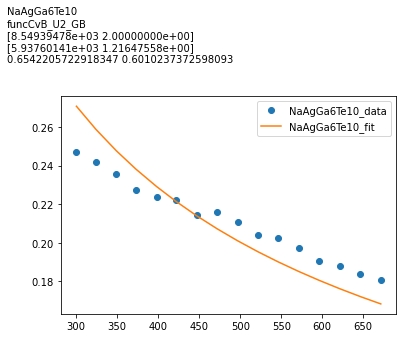

Na2Ga6Te10
TD = 169.3
vs = 1847
grainsize = 5e-05
[224.88516847   4.08512285]
[22.98227074  0.07687026]
Stats for: funcCvB_U2_GB
R_sq = 0.9974982789567615
Adj_R_sq = 0.9971133987962633


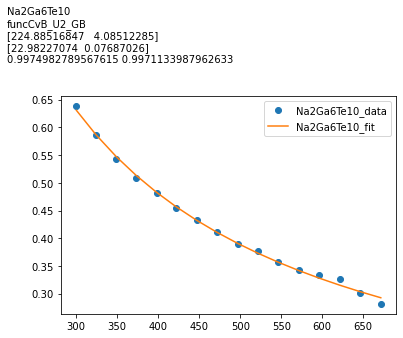

PbGa6Te10
TD = 164.0
vs = 1753
grainsize = 5e-05
[556.56131553   4.51085723]
[82.73979895  0.19821417]
Stats for: funcCvB_U2_GB
R_sq = 0.9906671320475642
Adj_R_sq = 0.9892313062087279


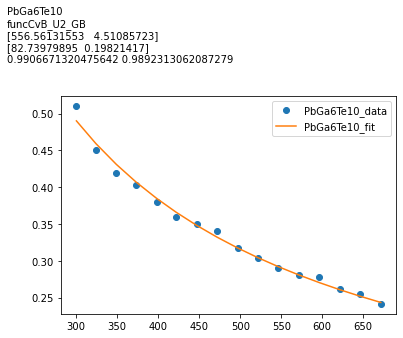

SnGa6Te10
TD = 170.7
vs = 1814
grainsize = 5e-05
[593.00736943   4.28174803]
[85.1839818   0.20322915]
Stats for: funcCvB_U2_GB
R_sq = 0.9906544851376327
Adj_R_sq = 0.9892167136203454


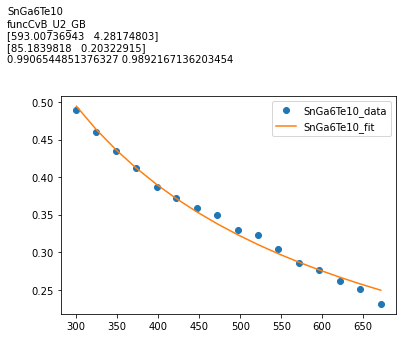

CaGa6Te10
TD = 171.3
vs = 1843
grainsize = 5e-05
[1473.6703145    2.3821924]
[2.11786781e+02 2.08517504e-01]
Stats for: funcCvB_U2_GB
R_sq = 0.9903286736171385
Adj_R_sq = 0.9888407772505444


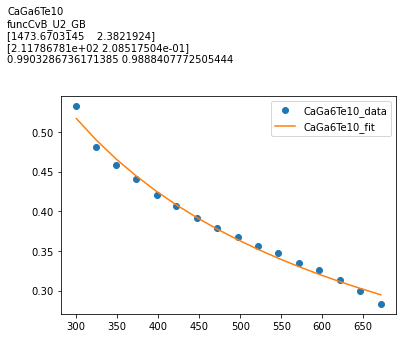

In [3]:
#Data

NaAg_name = "NaAgGa6Te10"
NaAg_T_list = np.asarray([300.15,323.95,348.85,372.95,397.85,421.65,446.65,471.55,496.65,521.55,546.35,571.35,596.35,621.35,646.45,671.35])
NaAg_k_list = np.asarray([0.2474,0.24214,0.23556,0.22766,0.22372,0.2224,0.2145,0.21582,0.21056,0.20398,0.20266,0.1974,0.19082,0.18792,0.18397,0.18073])
NaAg_TD = 161.9
NaAg_vs = 1750
NaAg_grain = 50.0E-6

Na2_name = "Na2Ga6Te10"
Na2_T_list = np.asarray([300.15,323.95,348.85,372.95,397.85,421.65,446.65,471.55,496.65,521.55,546.35,571.35,596.35,621.35,646.45,671.35])
Na2_k_list = np.asarray([0.63816,0.58603,0.54253,0.50798,0.48111,0.45424,0.43249,0.41073,0.39026,0.37619,0.35699,0.34292,0.33396,0.32628,0.30197,0.2815])
Na2_TD = 169.3
Na2_vs = 1847
Na2_grain = 50.0E-6

Pb_name = "PbGa6Te10"
Pb_T_list = np.asarray([300.15,323.95,348.85,372.95,397.85,421.65,446.65,471.55,496.65,521.55,546.35,571.35,596.35,621.35,646.45,671.35])
Pb_k_list = np.asarray([0.5099,0.45082,0.41871,0.4033,0.38018,0.35963,0.34935,0.34036,0.31724,0.3044,0.29027,0.28128,0.27743,0.26202,0.25431,0.24147])
Pb_TD = 164.0
Pb_vs = 1753
Pb_grain = 50.0E-6

Sn_name = "SnGa6Te10"
Sn_T_list = np.asarray([300.15,323.95,348.85,372.95,397.85,421.65,446.65,471.55,496.65,521.55,546.35,571.35,596.35,621.35,646.45,671.35])
Sn_k_list = np.asarray([0.48975,0.46051,0.43533,0.41201,0.38739,0.37185,0.35896,0.34982,0.32909,0.32261,0.30447,0.28633,0.27633,0.26135,0.25135,0.23135])
Sn_TD = 170.7
Sn_vs = 1814
Sn_grain = 50.0E-6

Ca_name = "CaGa6Te10"
Ca_T_list = np.asarray([300.15,323.95,348.85,372.95,397.85,421.65,446.65,471.55,496.65,521.55,546.35,571.35,596.35,621.35,646.45,671.35])
Ca_k_list = np.asarray([0.53257,0.48095,0.45828,0.44066,0.42051,0.40666,0.39156,0.37897,0.36763,0.3563,0.34749,0.3349,0.32609,0.3135,0.29965,0.28328])
Ca_TD = 171.3
Ca_vs = 1843
Ca_grain = 50.0E-6

Pb_LT_name = "PbGa6Te10_low_temp"
Pb_LT_T_list_full = np.asarray([3.03081,3.03807,3.29228,3.61696,3.9395,4.27595,4.6048,4.94077,5.27262,5.63407,6.0155,6.39871,6.79257,7.21049,7.64232,8.08164,8.5419,9.01666,9.50827,10.00562,10.51689,11.04812,11.58503,12.13613,12.7091,13.29013,13.87973,14.4807,15.09426,15.71698,16.35253,17.00051,17.67388,18.35327,19.04889,19.77081,20.5065,21.26211,22.03496,22.82709,23.65123,24.50388,25.37859,26.29537,27.24336,28.23892,29.2783,30.36988,31.5263,32.71915,33.987,35.34081,36.79107,38.35327,40.01075,41.7712,43.57255,45.50552,48.76239,53.44362,59.15672,65.51351,71.92763,79.40972,87.9557,96.55573,105.23228,297.55,322.25,347.75,373.55,398.75,423.65,447.75,473.25,498.65,523.85,548.85,573.95,598.95,623.95,648.75,673.75,698.75,723.65,748.65,773.65])
Pb_LT_k_list_full = np.asarray([1.60082,1.61897,1.85618,2.16608,2.421,2.70876,3.07203,3.21649,3.42741,3.5836,3.73978,3.66609,3.78973,3.9621,3.97158,4.125,4.25883,4.2878,4.24909,4.25346,4.34091,4.36907,4.34149,4.30281,4.27156,4.27682,4.22519,4.10428,4.077,4.03397,3.98896,3.92495,3.8723,3.78903,3.74261,3.65631,3.57138,3.49944,3.42923,3.37925,3.26353,3.21221,3.14204,3.04847,2.9945,2.93119,2.84959,2.79143,2.71395,2.64723,2.59456,2.51392,2.45065,2.38127,2.31114,2.25102,2.19196,2.12849,1.99562,1.87885,1.74461,1.65449,1.57761,1.47661,1.41837,1.33012,1.24678,0.5099,0.45082,0.41871,0.4033,0.38018,0.35963,0.34935,0.34036,0.31724,0.3044,0.29027,0.28128,0.27743,0.26202,0.25431,0.24147,0.20807,0.19394,0.19266,0.19137])
max_item = -20
Pb_LT_T_list = Pb_LT_T_list_full[:max_item]
Pb_LT_k_list = Pb_LT_k_list_full[:max_item]
Pb_LT_TD = 164
Pb_LT_vs = 1753
Pb_LT_grain = 25.0E-6



NaAg = Sample(NaAg_name, NaAg_T_list, NaAg_k_list, NaAg_TD, NaAg_vs, NaAg_grain)
Na2 = Sample(Na2_name, Na2_T_list, Na2_k_list, Na2_TD, Na2_vs, Na2_grain)
Pb = Sample(Pb_name, Pb_T_list, Pb_k_list, Pb_TD, Pb_vs, Pb_grain)
Sn = Sample(Sn_name, Sn_T_list, Sn_k_list, Sn_TD, Sn_vs, Sn_grain)
Ca = Sample(Ca_name, Ca_T_list, Ca_k_list, Ca_TD, Ca_vs, Ca_grain)


Pb_LT = Sample(Pb_LT_name, Pb_LT_T_list, Pb_LT_k_list, Pb_LT_TD, Pb_LT_vs, Pb_LT_grain)

Sample_list_1 = [NaAg, Na2, Pb, Sn, Ca]
Sample_list_1a = [NaAg]
Sample_list_1b = [Pb]
Sample_list_2 = [Pb_LT]


for item in Sample_list_1:
    item.report()
    item.fit_CvB_U2_GB()
    item.stat()
    item.draw(print_to_file=False, x_log = False)
    #item.fit_to_file()

    
#for item in Sample_list_1:
#    print(item.report_result())

